Here a notebook to fit different functions to our participant data

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import matplotlib.transforms as transforms
import matplotlib
import pandas as pd
import os
import os.path
from scipy.optimize import curve_fit

In [6]:
dname = os.path.dirname(os.getcwd()) + '/data_loading/data_v2_quotes/'
dname

'c:\\Users\\Jirko\\Desktop\\Hip_Lab\\analysis_scripts/data_loading/data_v2_quotes/'

load data

In [7]:
ACCURACY = np.load(dname + 'ACCURACY_New.npy')
acc_first_prop = np.load(dname + 'Acc_first_prop_New.npy')
acc_second_prop = np.load(dname + 'acc_second_prop_New.npy')
acc_third_prop = np.load(dname + 'acc_third_prop_New.npy')

check shape

In [8]:
n_sujs, n_blocs, n_trials = ACCURACY.shape
# ACCURACY.shape
acc_first_prop.shape
acc_second_prop.shape
# ACCURACY[0,:,:]

(49, 8, 16)

compute subject wise average

In [9]:
# overall
ACCURACY_M_SUJS = np.nanmean(ACCURACY, axis=2)

# for our three hierarchical levels
subj_acc_first = np.nanmean(acc_first_prop, axis=2)
subj_acc_second = np.nanmean(acc_second_prop, axis=2)
subj_acc_third = np.nanmean(acc_third_prop, axis=2)

# # find low performers
# low_indices = np.where(ACCURACY_M_SUJS[:,7] < .7)
# low_indices

A function to plot our subjects

In [20]:
def plot_accuracy_indi(subj_means, fig_name, fig_title, chance_level=False):
    # Define figure
    fig, ax = plt.subplots(1, 1, figsize=(9, 4), dpi=300, facecolor='w')

    # Individual data
    for i in range(subj_means.shape[0]-40):
        ax.plot(
            np.arange(n_blocs),
            subj_means[i,:]
        )
    if chance_level:
        ax.axhline(y=chance_level, color='r', linestyle='--' )
    # Aesthetics
    ax.set_title(fig_title, fontweight='bold')
    ax.set_ylim(0.3, 1.05)
    ax.set_xlabel('Block #')
    ax.set_ylabel('Accuracy')

    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    plt.tight_layout()
    # fig.savefig(fig_name)

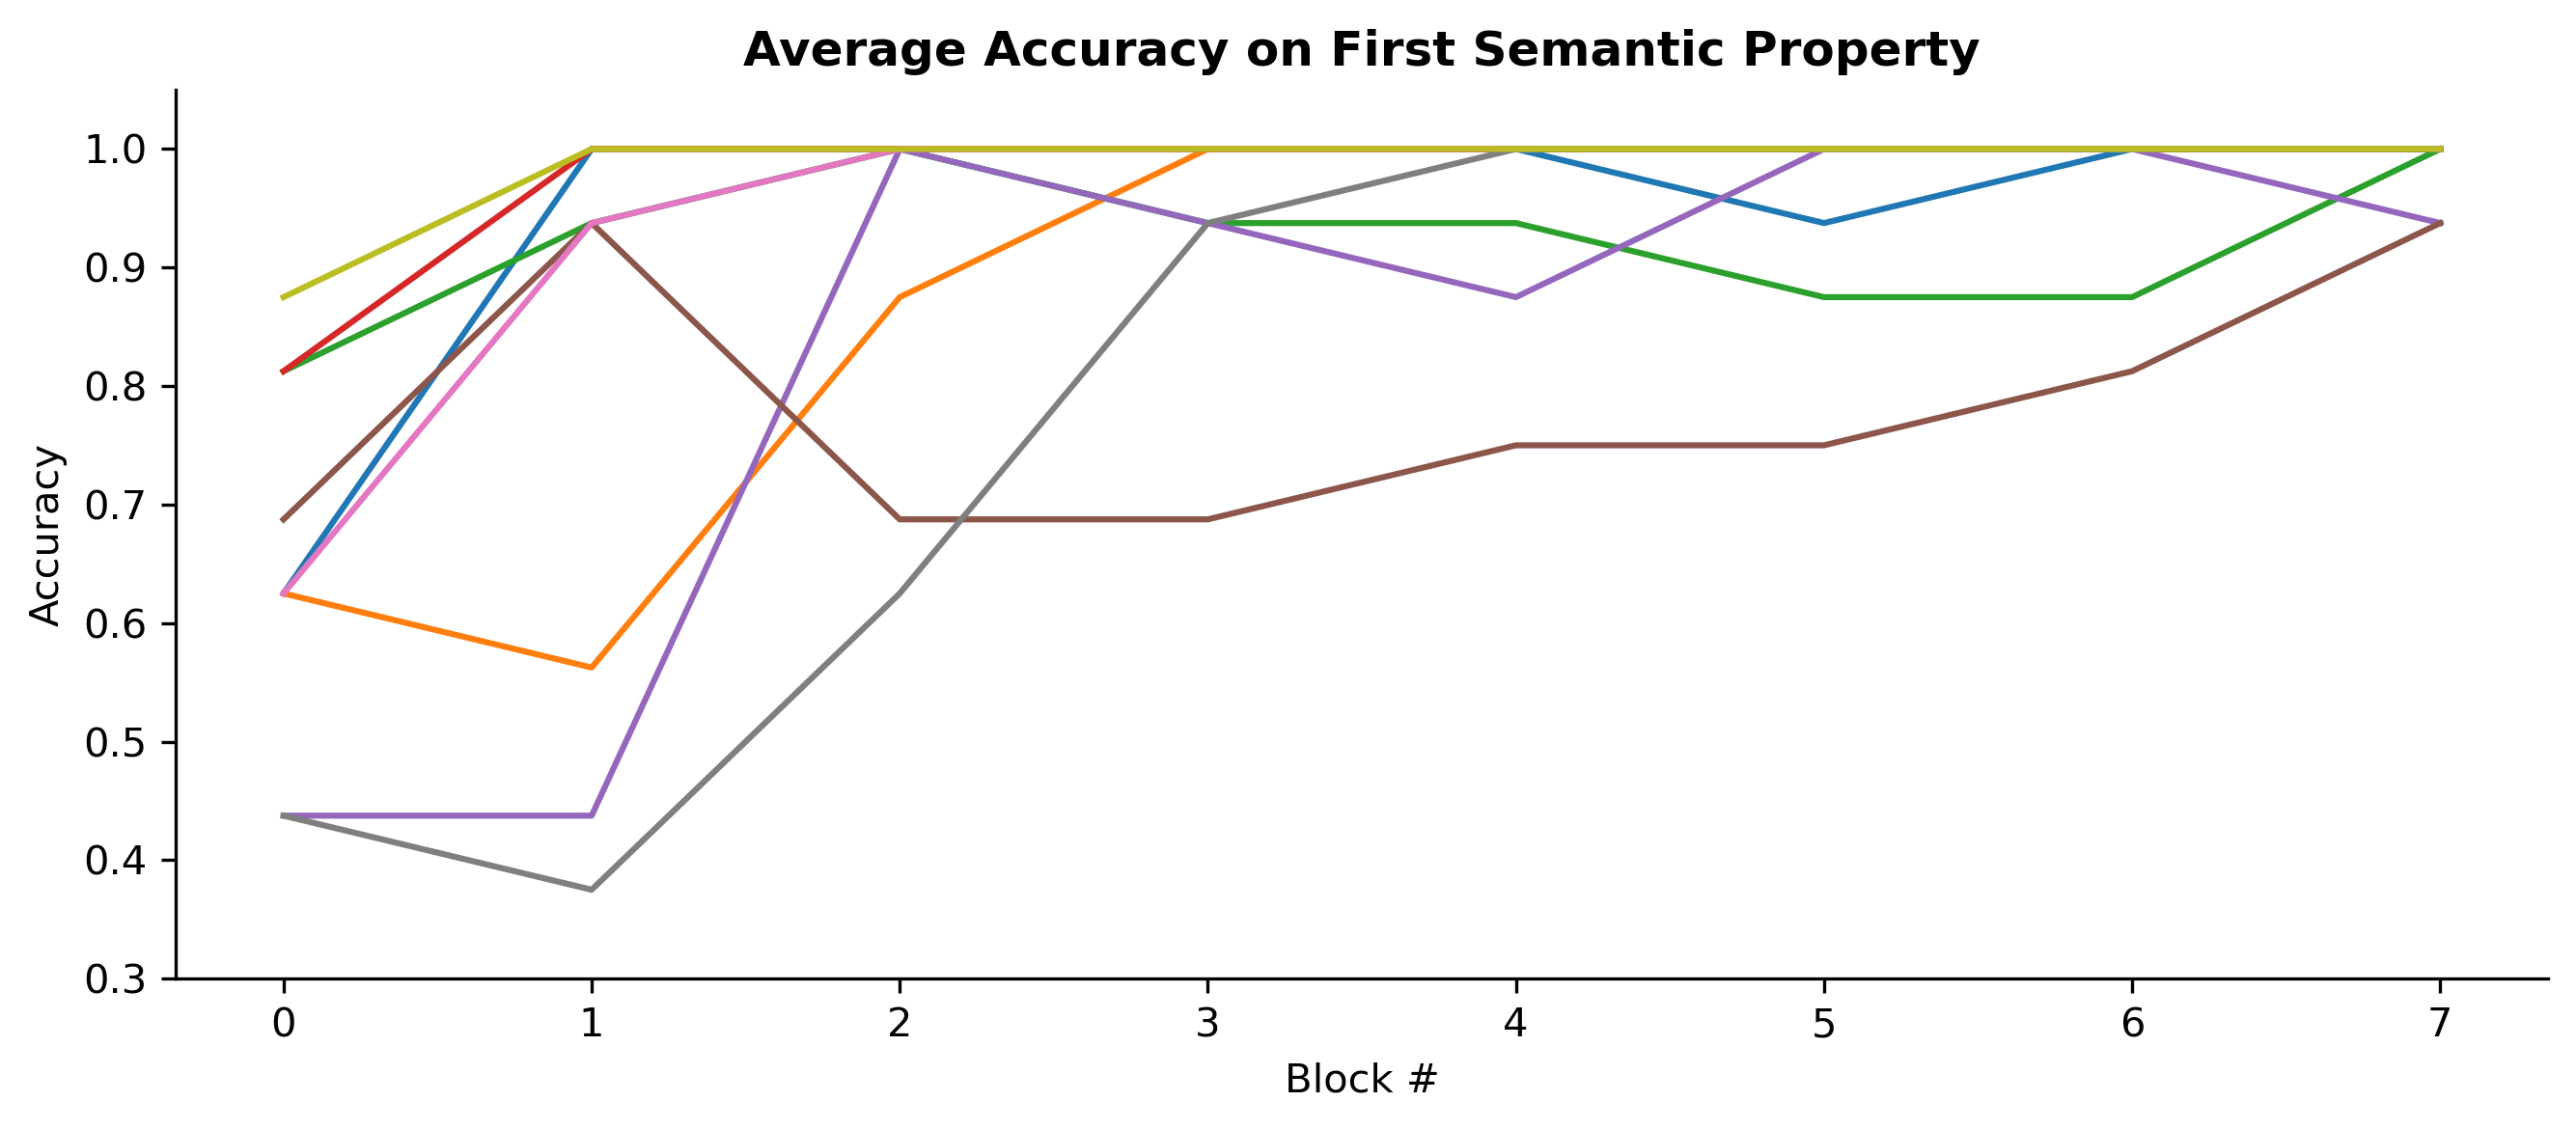

In [21]:
func_name = 'figures_new/fig_2_new_indi.svg'
fig_title = 'Average Accuracy on First Semantic Property'
plot_accuracy_indi(subj_acc_first, func_name, fig_title)

Now lets try to fit some functions, first define the relevant functions.

In [268]:
def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

def linear(x, w, b):
    y = x * w + b
    return y

def relu(x, w, b1, b2):
    y = np.maximum((x * w - b1),0) + b2
    return y

def heaviside(x, b1, b2):
    y = 1 * (x + b1 > 0) * b2
    return y

[-8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.]


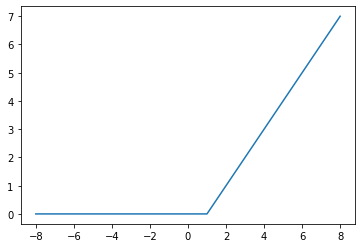

In [259]:
x = np.linspace(-8, 8, 17)
print(x)
y = relu(x, 1, 1, 0)
plt.plot(x,y, label='fit')

Make the test data

In [160]:
x_data = np.linspace(1, 8, 8)
y_data = subj_acc_second[1,:]
# x_data.shape

In [161]:
p0 = [max(y_data), 1, min(y_data)] # this is an mandatory initial guess
bound = ([1, -np.inf, -np.inf], [np.inf, np.inf, 8])
# p0 = [1, min(y_data)] # this is an mandatory initial guess
# bound = ([-np.inf, -np.inf], [np.inf, np.inf])
popt, pcov = curve_fit(sigmoid, x_data, y_data, p0,bounds=bound, method='dogbox')
print(popt)

[2.19366782 0.83370562 0.03983662]


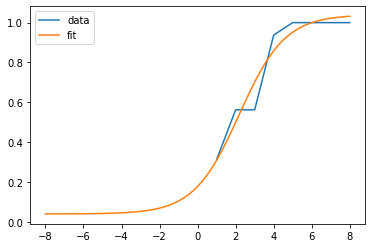

In [162]:
x = np.linspace(-8, 8, 90)
y = sigmoid(x, *popt)
plt.plot(x_data, y_data, label='data')
plt.plot(x,y, label='fit')
plt.legend()

Now we create a function to fit to each participant

In [172]:

def part_fit(function, data, n_params, p0, bound):
    """make fit to each participant and return the params

    Args:
        function (_type_): _description_
        data (_type_): _description_
    """
    all_popt = np.full((data.shape[0], n_params), np.nan)
    # loop over each participant
    x_data = np.linspace(1, data.shape[1], 8)

    for i in range(data.shape[0]):
        y_data = data[i,:]

        popt, pcov = curve_fit(function, x_data, y_data, p0, method='dogbox',bounds=bound, maxfev=5000)
        
        all_popt[i,:] = popt

    return all_popt

fit the sigmoid to our participants

In [286]:
p0 = [max(y_data), 1] # this is an mandatory initial guess
bound = ([1, -np.inf], [np.inf, np.inf])

all_popt = part_fit(sigmoid, subj_acc_third, 2, p0, bound)
df = pd.DataFrame(all_popt, columns = ['x0','k'])
df.to_csv("params/third/sigmoid.csv")
print(all_popt.shape)

(49, 2)


plot

(array([38.,  4.,  4.,  1.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([-0.10501312,  0.8893473 ,  1.88370772,  2.87806814,  3.87242856,
         4.86678898,  5.8611494 ,  6.85550982,  7.84987025,  8.84423067,
         9.83859109]),
 <BarContainer object of 10 artists>)

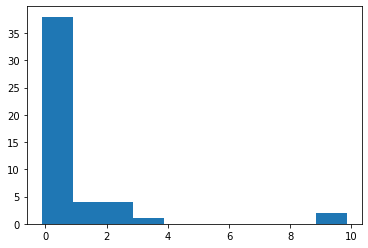

In [179]:
plt.hist(all_popt[:,1],10)

Make a fit for the linear model

(49, 2)


(array([ 1.,  3.,  3.,  3., 11., 16.,  6.,  3.,  0.,  3.]),
 array([-0.05580357, -0.03861607, -0.02142857, -0.00424107,  0.01294643,
         0.03013393,  0.04732143,  0.06450893,  0.08169643,  0.09888393,
         0.11607143]),
 <BarContainer object of 10 artists>)

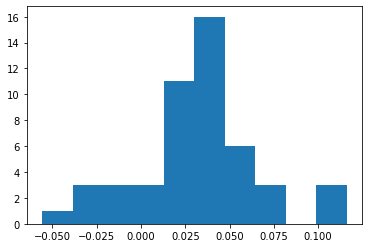

In [284]:
# p0 = [max(y_data), 1] # this is an mandatory initial guess
# bound = ([1, -np.inf], [np.inf, np.inf])

p0 = [1, min(y_data)] # this is an mandatory initial guess
bound = ([-np.inf, -np.inf], [np.inf, np.inf])

all_popt = part_fit(linear, subj_acc_third, 2, p0, bound)
df = pd.DataFrame(all_popt, columns = ['w','b'])
df.to_csv("params/third/linear.csv")
print(all_popt.shape)
plt.hist(all_popt[:,0],10)

array([0.015625, 0.90625 ])

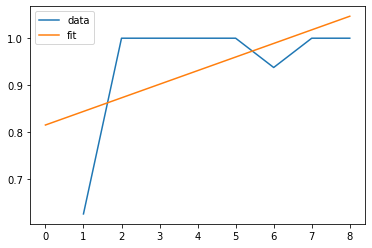

In [277]:
x_data = np.linspace(1, 8, 8)
y_data = subj_acc_first[0,:]

x = np.linspace(0, 8, 90)
y = linear(x, *all_popt[0,:])
plt.plot(x_data, y_data, label='data')
plt.plot(x,y, label='fit')
plt.legend()
all_popt[3,:]

Now for the Relu function

(49, 3)


(array([5., 7., 7., 6., 9., 3., 2., 4., 2., 4.]),
 array([0.19642857, 0.25959821, 0.32276786, 0.3859375 , 0.44910714,
        0.51227679, 0.57544643, 0.63861607, 0.70178571, 0.76495536,
        0.828125  ]),
 <BarContainer object of 10 artists>)

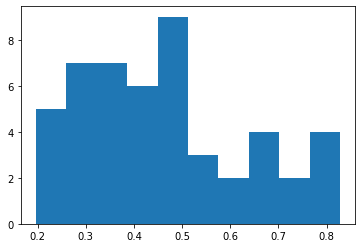

In [282]:
# p0 = [max(y_data), 1] # this is an mandatory initial guess
# bound = ([1, -np.inf], [np.inf, np.inf])

p0 = [1, min(y_data), 0] # this is an mandatory initial guess
bound = ([0, 0, 0], [1, 8, 1])

all_popt = part_fit(relu, subj_acc_third, 3, p0, bound)
df = pd.DataFrame(all_popt, columns = ['w','b1',"b2"])
df.to_csv("params/third/relu.csv")
print(all_popt.shape)
plt.hist(all_popt[:,2],10)

(array([ 2.,  2.,  8., 10.,  7.,  8.,  0.,  2.,  5.,  5.]),
 array([0.24107143, 0.30223214, 0.36339286, 0.42455357, 0.48571429,
        0.546875  , 0.60803571, 0.66919643, 0.73035714, 0.79151786,
        0.85267857]),
 <BarContainer object of 10 artists>)

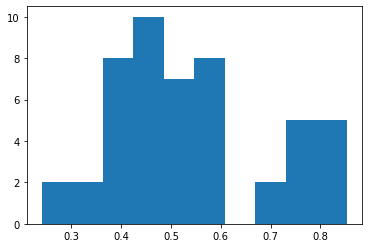

In [263]:
plt.hist(all_popt[:,2],10)

array([0.06175595, 0.        , 0.60491071])

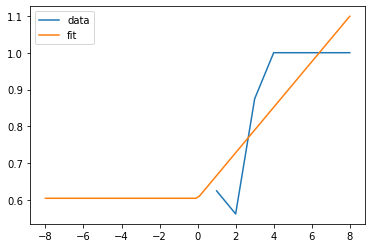

In [280]:
x_data = np.linspace(1, 8, 8)
y_data = subj_acc_first[1,:]

x = np.linspace(-8, 8, 90)
y = relu(x, *all_popt[1,:])
plt.plot(x_data, y_data, label='data')
plt.plot(x,y, label='fit')
plt.legend()
all_popt[1,:]